# 03 - Introduction to seismic inversion, Full-Waveform Inversion (FWI)

This notebook is the third in a series of tutorial highlighting various aspects of seismic inversion based on Devito operators. In this second example we aim to highlight the core ideas behind seismic inversion, where we create an image of the subsurface from field recorded data. This tutorial follows on the modelling tutorial and will reuse the modelling and velocity model.

## Inversion requirement

Seismic inversion relies on two known parameters:

- **Field data** - or also called **recorded data**. This is a shot record corresponding to the true velocity model. In practice this data is auired as described in the first tutorial. In order to siplify this tutorial we will fake field data by modelling it with the true velocity model.

- **Initial velocity model**. This is a velocity model that has been obtained by processing the field data. This model is a rough and very smooth estimate of the velocity as an initial estimate for the inversion. This is a necessary requirement for any optimization (method).

## Inversion computational setup

In this tutorial, we will introduce the gradient operator. This operator corresponds to the imaging condition introduced in the previous tutorial with some minor modifications that are defined by the objective function and its derivative. We will define this two terms in the tutorial too.

## Notes on the operators.

As we already describe the creation of a forward modelling operator, we will only call an wraped function here. This wrapers already contains all the necessary operator for seismic modeling, imaging and inversion, however any new operator will be fully described and only used from the wrapper in the next tutorials.

In [1]:
# As we already saw the output of the code generation, we are turning
# of the logging to clean up the term|inal due to a larger number of
# calls to the operators
from devito.logger import set_log_level
set_log_level('ERROR')

# True and smooth velocity models.

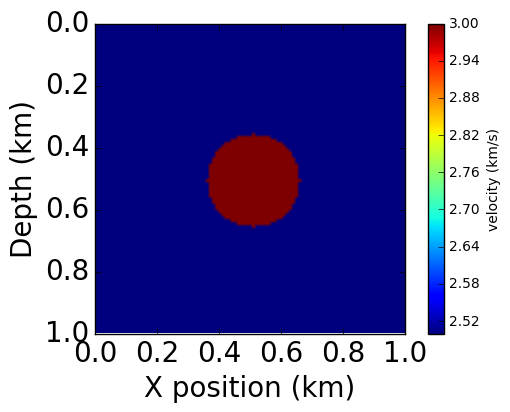

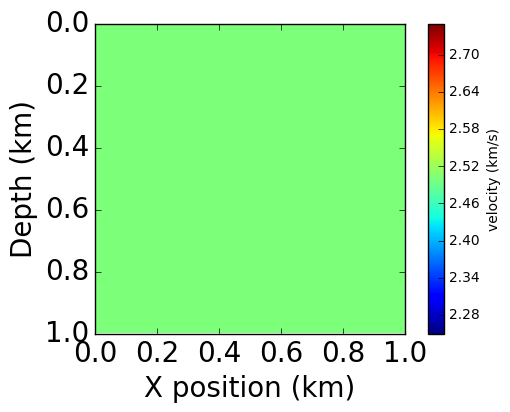

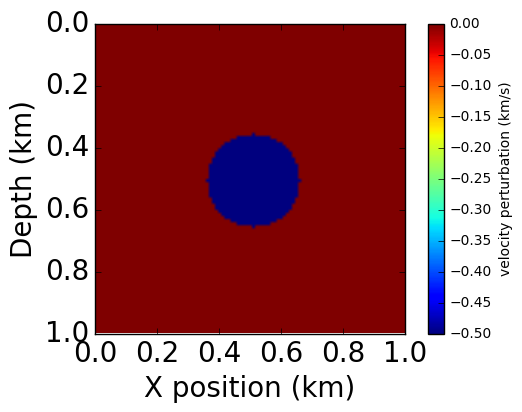

In [2]:
import numpy as np
from examples.seismic import plot_velocity, plot_perturbation
%matplotlib inline

# We import now the Model abstraction for seismic modeling
from examples.seismic import Model

# Define a physical size
shape = (101, 101)  # Number of grid point (nx, nz)
spacing = (10., 10.)  # Grid spacing in m. The domain size is now 1km by 1km
origin = (0., 0.)  # What is the location of the top left corner. This is necessary to define
# the absolute location of the source and receivers

# Define a velocity profile. The velocity is in km/s
v = 2.5*np.ones(shape, dtype=np.float32)
a, b = 51, 51
n = 101
r = 15

y,x = np.ogrid[-a:n-a, -b:n-b]
mask = x*x + y*y <= r*r

v[mask] = 2.5 + .2*2.5

# With the velocity and model size defined, we can create the seismic model that
# encapsulate this properties. We also define the size of the absorbing layer as 10 grid points
model = Model(vp=v, origin=origin, shape=shape,
              spacing=spacing, nbpml=40)

plot_velocity(model)

# We are now smoothing the velocity model

v_smooth = 2.5*np.ones(shape, dtype=np.float32)
# encapsulate this properties. We also define the size of the absorbing layer as 10 grid points
model0 = Model(vp=v_smooth, origin=origin, shape=shape,
               spacing=spacing, nbpml=40)

plot_velocity(model0)

plot_perturbation(model0, model)

##### True and smooth data

We can now generate the shot record correspondingto both models. The difference between this two record will be the basis of the imaging procedure. The acquisition geometry is the same as in the previous tutorial.

In [3]:
# Acquisition geometry
from examples.seismic import PointSource, Receiver
t0 = 0.
tn = 700.  # Simulation last 1 second (1000 ms)
f0 = 0.010  # Source peak frequency is 10Hz (0.010 kHz)

dt = model.critical_dt  # Computational time step. This value is obtained from
# the maximum velocity and the grid size and is defined with the CFL condition. This is the 
# numerical condition to ensure the discrete model is stable. We will define it properly
# later on but it is required here.
nt = int(1+(tn-t0)/dt)  # Discrete time axis length


# Source initalization for a single source
def Ricker(t, f0):
    r = (np.pi * f0 * (t - 1./f0))
    return (1 - 2.*r**2) * np.exp(-r**2)

src = PointSource(name='src', npoint=1, ntime=nt, ndim=2)
src.data[:, 0] = Ricker(np.linspace(t0, tn, nt), f0)

# Set location of the source
src.coordinates.data[0, 0] = 30.
src.coordinates.data[0, 1] = origin[1] + shape[1] * spacing[1] * 0.5

# Receiver initialization. This one does not contain any
# data as it will be computed during the simulation and correspond
# to the true model
true_d = Receiver(name='rec', npoint=101, ntime=nt, ndim=2)
true_d.coordinates.data[:, 0] = 970.
true_d.coordinates.data[:, 1] = np.linspace(0, origin[1] + shape[1] * spacing[1], num=101)

# Receiver initialization. This one does not contain any
# data as it will be computed during the simulation and correspond
# to the smooth model
smooth_d = Receiver(name='rec', npoint=101, ntime=nt, ndim=2)
smooth_d.coordinates.data[:, 0] = 970.
smooth_d.coordinates.data[:, 1] = np.linspace(0, origin[1] + shape[1] * spacing[1], num=101)

In [4]:
# Forward operator 
from examples.seismic.acoustic import AcousticWaveSolver
from devito.interfaces import TimeData

solver = AcousticWaveSolver(model, src, true_d, space_order=4)
solver.forward(src=src, rec=true_d, m=model.m)

(rec(time, p_rec),
 u(t, x, y),
 PerformanceSummary([('loop_p_src_1',
                      PerfEntry(time=0.00012199999999999975, gflopss=0.16769672131147573, oi=0.7306785714285714, itershape=[499, 1], datashape=[500, 1])),
                     ('loop_p_rec_2',
                      PerfEntry(time=0.0007660000000000073, gflopss=2.1712362924281776, oi=1.37225, itershape=[499, 101], datashape=[500, 101])),
                     ('main',
                      PerfEntry(time=0.04277299999999992, gflopss=7.102160732237639, oi=1.159079091755441, itershape=[499, 179, 179], datashape=[500, 181, 181]))]))

In [5]:
# Smooth data
solver.forward(src=src, rec=smooth_d, m=model0.m)

(rec(time, p_rec),
 u(t, x, y),
 PerformanceSummary([('loop_p_src_1',
                      PerfEntry(time=0.00011199999999999981, gflopss=0.18266964285714316, oi=0.7306785714285714, itershape=[499, 1], datashape=[500, 1])),
                     ('loop_p_rec_2',
                      PerfEntry(time=0.0007140000000000072, gflopss=2.329365546218464, oi=1.37225, itershape=[499, 101], datashape=[500, 101])),
                     ('main',
                      PerfEntry(time=0.04630899999999987, gflopss=6.559863547042709, oi=1.159079091755441, itershape=[499, 179, 179], datashape=[500, 181, 181]))]))

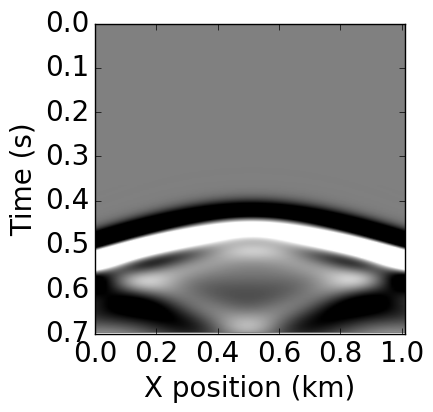

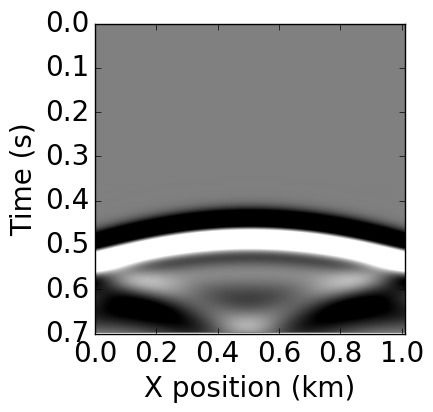

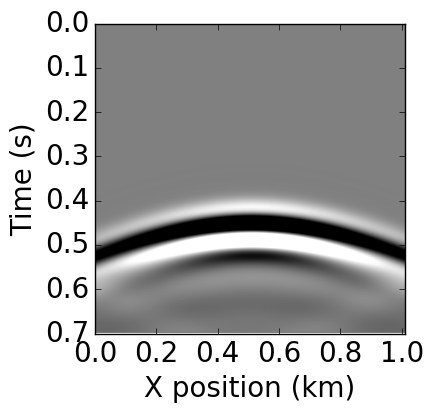

In [6]:
# Shot record for the true and smooth velocity model and the difference

from examples.seismic import plot_shotrecord

plot_shotrecord(true_d.data, origin, spacing, shape, t0, tn)

plot_shotrecord(smooth_d.data, origin, spacing, shape, t0, tn)

plot_shotrecord(smooth_d.data - true_d.data, origin, spacing, shape, t0, tn, diff=True)

The only difference between the smooth and the true velocity model is the value of the velocity. The dimensions of the model are unchanged. We can therefore reuse the forward modelling operator we just build and only specify the new velocity model, the shot record we want the result to be in and a new initialized wavefield.

If the shot record is not specified, the data will still be computed but will overwrite the true shot record. Concerning the initialization of a new wavefield, this comes from the simplified interface of this tutorial. In practice, a warapper would be built around the operator to reinitialize any field at runtime.

# Full-Waveform Inversion


## Formulation

Full-waveform inversion (FWI) aims to invert an accurate model of the
discrete wave velocity, $\mathbf{c}$, or equivalently the square
slowness of the wave, $\mathbf{m} = \frac{1}{\mathbf{c}^2}$, from a given
set of measurements of the pressure wavefield
$\mathbf{u}$. [refs] shows that this can be expressed as the following PDE-constrained optimization problem:

\begin{aligned}
	\mathop{\hbox{minimize}}_{\mathbf{m}} \Phi_s(\mathbf{m})&=\frac{1}{2}\left\lVert\mathbf{P}_r
	\mathbf{u} - \mathbf{d}\right\rVert_2^2 \\
	\mathbf{u} &= \mathbf{A}(\mathbf{m})^{-1} \mathbf{P}_s^T \mathbf{q}_s, 
\end{aligned}

where $\mathbf{P}_r$ is the sampling operator at the receiver
locations, $\mathbf{P}_s^T$ is the injection operator at the source
locations, $\mathbf{A}(\mathbf{m})$ is the operator
representing the discretized wave equation matrix, $\mathbf{u}$ is the
discrete synthetic pressure wavefield, $\mathbf{q}_s$ is the
corresponding pressure source and $\mathbf{d}$ is the measured data. It
is worth noting that $\mathbf{m}$ is the
unknown in this formulation and that multiple implementations of the
wave equation operator $\mathbf{A}(\mathbf{m})$ are possible. We already defined
a concrete solver scheme for $\mathbf{A}(\mathbf{m})$ in the forst tutorial , including appropriate
implementations of the sampling operator $\mathbf{P}_r$ and source term
$\mathbf{q}_s$.

To solve this optimization problem using a gradient-based method, we use the
adjoint-state method to evaluate the gradient $\nabla\Phi_s(\mathbf{m})$:

\begin{align}
 \nabla\Phi_s(\mathbf{m})=\sum_{\mathbf{t} =1}^{n_t}\mathbf{u}[\mathbf{t}] \mathbf{v}_{tt}[\mathbf{t}] =\mathbf{J}^T\delta\mathbf{d}_s,
\end{align}

where $n_t$ is the number of computational time steps, $\delta\mathbf{d}_s = \left(\mathbf{P}_r \mathbf{u} - \mathbf{d} \right)$ is the data residual (difference between the measured data and the modelled data), $\mathbf{J}$ is the Jacobian operator and $\mathbf{v}_{tt}$ is the second-order time derivative of the adjoint wavefield solving:

\begin{align}
 \mathbf{A}^T(\mathbf{m}) \mathbf{v} = \mathbf{P}_r^T \delta\mathbf{d}.
\end{align}

We see that the gradient of the FWI function is the previously defined imaging condition with an extra second-order time derivative. We will therefore reuse the operators defined previously inside a Devito wrapper.


## Computational considerations

As we just explaine, the forward wave-equation is solved forward in time while the adjoint wave-equation is solved in a reversed time order. Therefor, the correlation of this two field over time requires to store one of the two fields. The computational workflow for imaging follows:

- Simulate the forward wave-equation with the background veocity model to get the synthetic data and save the full wavefield $\mathbf{u}$
- Compute the data residual
- Back-propagate the data residual and compute on the fly the Image contribution at each time step. 

This workflow is applied to multiple source position and sumed to obatain the full image of the subsurface.

In [7]:
from devito import Backward, Operator
from devito import t, time

from sympy import solve, Eq
from sympy.abc import s, h


def image(model, rec, image, u, v):
    # We can now write the PDE
    pde = model.m * v.dt2 - v.laplace - model.damp * v.dt

    # This discrete PDE can be solved in a time-marching way updating u(t+dt) from the previous time step
    # Devito as a shortcut for u(t+dt) which is u.forward. We can then rewrite the PDE as
    # a time marching updating equation known as a stencil using sympy functions

    stencil = Eq(v.backward, solve(pde, v.backward)[0])
    # Finally we define the source injection and receiver read function to generate the corresponding code
    src_term = rec.inject(field=v, expr=rec * model.critical_dt ** 2 / model.m,
                          u_t=t - 1, p_t=time, offset=model.nbpml)
    # Correlate the forward and adjoint wavefield for the current time step and add it to the image
    image_update = Eq(image, image - u * v.dt2)

    op = Operator([stencil] + src_term + [image_update],
                  subs={s: model.critical_dt, h: model.spacing[0]},
                  time_axis=Backward)
    # Force compile the operator for simple reuse and correctness of the time axis
    op.apply()
    return op

In [8]:
from devito.interfaces import DenseData
# Number of sources
nsrc = 21
sources = np.linspace(0, 1000, num=nsrc)

In [9]:
# Initialize a data residual object
import matplotlib.pyplot as plt
# to the smooth model
residual = Receiver(name='recd', npoint=101, ntime=nt, ndim=2)
residual.coordinates.data[:, 0] = 970.
residual.coordinates.data[:, 1] = np.linspace(0, origin[1] + shape[1] * spacing[1], num=101)

# Gradient operator
v = TimeData(name='v', shape=model.shape_domain, time_order=2, space_order=4)
u0 = TimeData(name='ug', shape=model.shape_domain, time_order=2, space_order=4,
              save=True, time_dim=nt)
def full_grad(m_in):
    Im = DenseData(name='Im', shape=model.shape_domain, dtype=model.m.dtype)
    Imaging = image(model, residual, Im, u0, v)
    obj = 0.
    for i in range(0, nsrc):
        location = np.zeros((1, 2))
        location[0, 0] = 30.
        location[0, 1] = sources[i]
        src.coordinates.data[:] = location[:]
        # True data
        solver.forward(src=src, rec=true_d, m=model.m)
        # Smooth data (and save u0)
        u0.data[:] = 0.
        solver.forward(src=src, rec=smooth_d, m=m_in, save=True, u=u0)
        # gradient 
        residual.data[:] = smooth_d.data[:] - true_d.data[:]
        
#         plot_shotrecord(residual.data, origin, spacing, shape, t0, tn)
        
        obj += .5*np.linalg.norm(residual.data.reshape(-1))**2
        v.data[:] = 0.
        Imaging(ug=u0, vg=v, m=m_in, recd=residual)
    
    Im.data[0:25,:] = 0.
    Im.data[-25:,:] = 0.
    return obj, Im.data

In [10]:
ff, update = full_grad(model0.m)

('objective value is : ', 134306.69563353431)


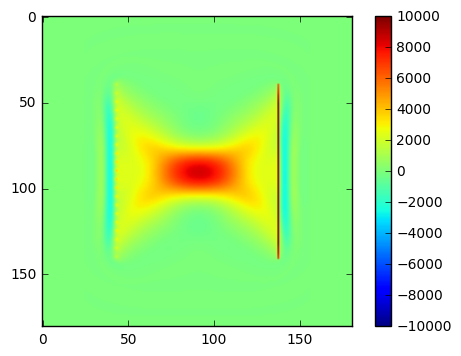

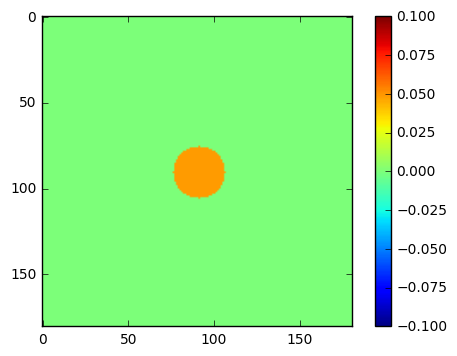

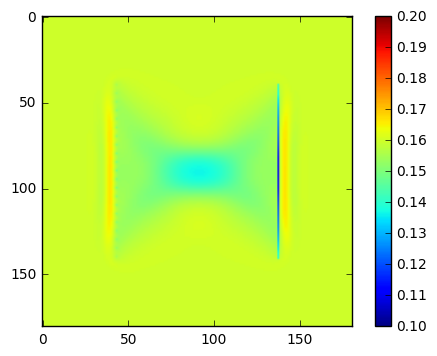

In [11]:

print("objective value is : ", ff)
plt.figure()
plt.imshow(np.transpose(update), vmin=-1e4, vmax=1e4)
plt.colorbar()
plt.figure()
plt.imshow(np.transpose(model0.m.data - model.m.data), vmin=-1e-1, vmax=1e-1)
plt.colorbar()
alpha = .05/np.max(update)
plt.figure()
plt.imshow(np.transpose(model0.m.data - alpha*update), vmin=.1, vmax=.2)
plt.colorbar()

And we have an image of the subsurface with a strong reflector at the original location.

In [12]:
# Basic gradient descent
maxiter = 10
hist = np.zeros((maxiter,1))
for i in range(0,maxiter):
    phi, direction = full_grad(model0.m)
    hist[i] = phi
    alpha = .01/np.max(direction)
    model0.m.data[:] = model0.m.data - alpha*direction
#     plt.figure()
#     plt.imshow(np.transpose(alpha*direction), vmin=-1e-1, vmax=1e-1)
#     plt.colorbar()
#     plt.figure()
#     plt.imshow(np.transpose(model0.m.data), vmin=.1, vmax=.2)
#     plt.colorbar()
    print('Objective value is ', phi, ' at iteration ', i+1)

('Objective value is ', 134306.69563353431, ' at iteration ', 1)
('Objective value is ', 93616.343665381952, ' at iteration ', 2)
('Objective value is ', 57606.663827797871, ' at iteration ', 3)
('Objective value is ', 29051.521711659341, ' at iteration ', 4)
('Objective value is ', 10810.109698584158, ' at iteration ', 5)
('Objective value is ', 3029.6905280865926, ' at iteration ', 6)
('Objective value is ', 1748.3609753454652, ' at iteration ', 7)
('Objective value is ', 1172.1012844065372, ' at iteration ', 8)
('Objective value is ', 832.39670286494061, ' at iteration ', 9)
('Objective value is ', 695.03517393496327, ' at iteration ', 10)


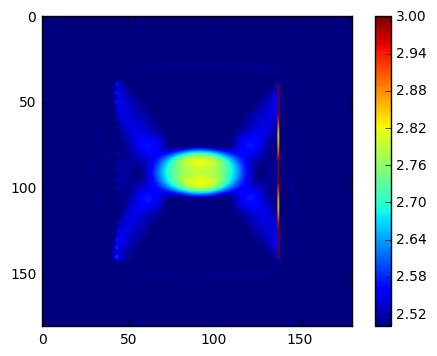

In [13]:
plt.figure()
plt.imshow(np.transpose(np.sqrt(1/model0.m.data)), vmin=2.5, vmax=3.)
plt.colorbar()

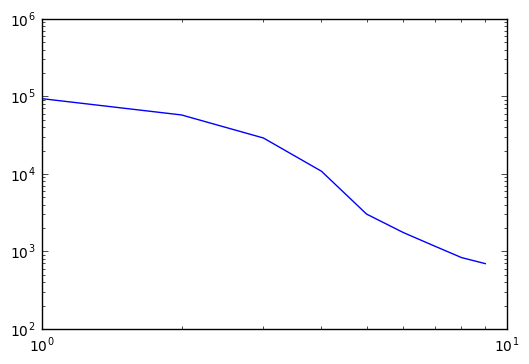

In [14]:
plt.figure()
plt.loglog(hist)